# Danish fire insurance data

In [17]:
%run preamble.py
ausautoBI8999 = pd.read_csv("Data/ausautoBI8999.csv")
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([dat.datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)
X = aus[aus["FinMth"].isin(np.arange(52, 60, 1))].AggClaim.values * 1e-6

## Descriptive statistics

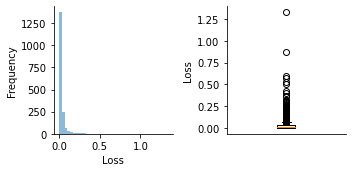

In [18]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(5, 2.5))
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(X, num_bins, alpha=0.5)
axs[1].boxplot(X)
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Loss")
axs[1].set_xticks([])
# plt.show()
sns.despine()
plt.savefig("Figures/hist_boxplot_danish_en.pdf")

## Preliminary extreme value theory analysis with pyextremes

<AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>

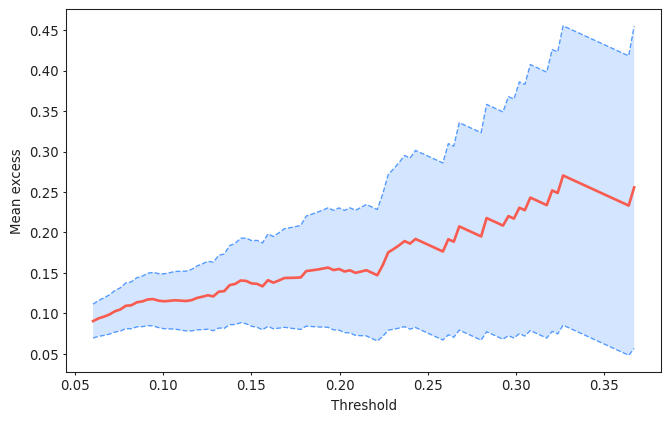

In [19]:
idx = pd.date_range("2018-01-01", periods=len(X), freq="D")
ts = pd.Series(X, index=idx)
model = evt.EVA(ts)
evt.plot_mean_residual_life(ts, extremes_type="high")

(<AxesSubplot:ylabel='Shape, $\\xi$'>,
 <AxesSubplot:xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

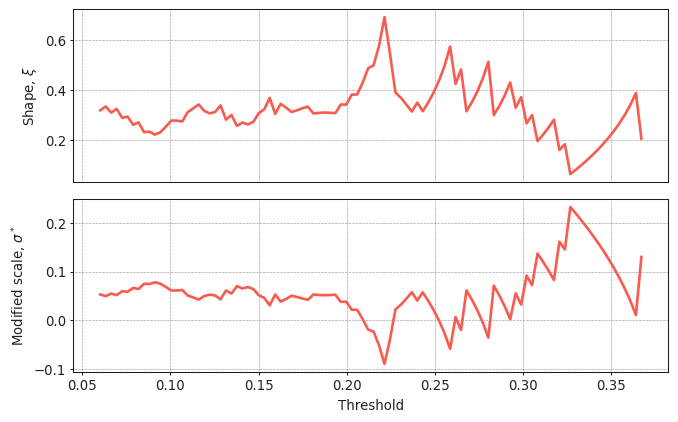

In [20]:
evt.plot_parameter_stability(ts)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

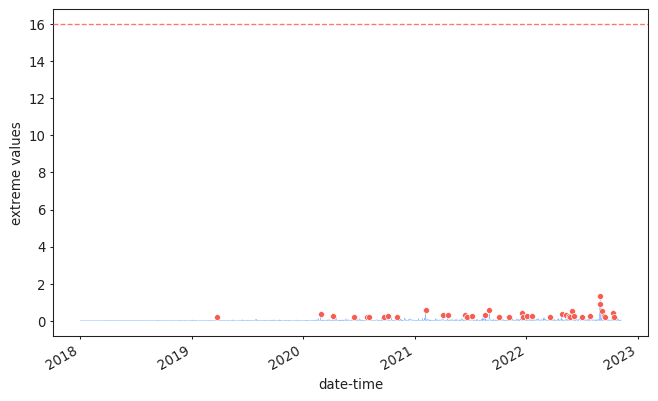

In [21]:
extremes = evt.get_extremes(ts, "POT", threshold=0.18, r="24H")
evt.plotting.plot_extremes(
    ts=ts,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=16,
    r="24H",
)

(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='extreme values'>,
  <AxesSubplot:title={'center':'Probability density plot'}, ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

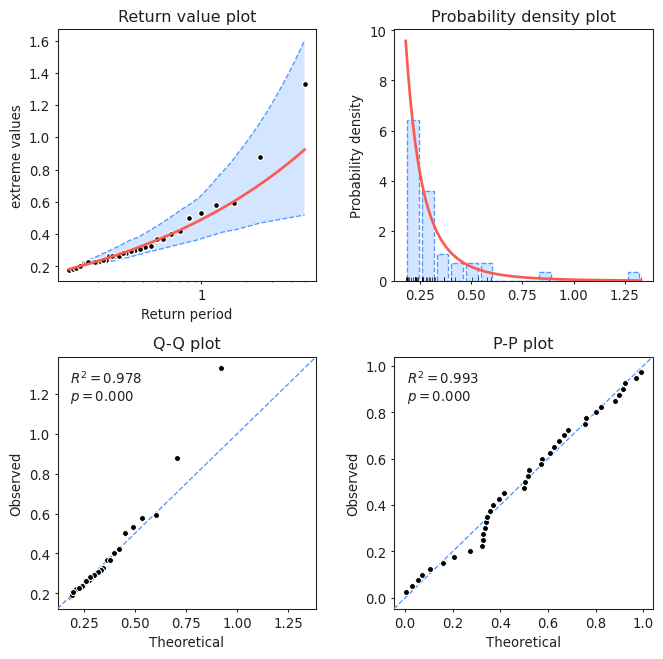

In [22]:
model.get_extremes( "POT", threshold=0.18, r="24H")
model.fit_model()
model.plot_diagnostic(alpha=0.95)

# Fitting splicing models to the data

In [66]:
f1, f2 =  bsm.loss_model("Gamma", ["r1", "m1"]), bsm.loss_model("Burr", ["r2", "m2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "disjoint") 
r1_prior, m1_prior = bsm.prior_model('gamma','r1', 1, 1), bsm.prior_model('gamma','m1', 1, 1)
r2_prior, m2_prior, σ2_prior = bsm.prior_model('gamma','r2', 1, 1), bsm.prior_model('gamma','m2',1, 1),\
bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1,1), bsm.prior_model('uniform', 'p', 0, 1)
prior_spliced_model = bsm.independent_priors([r1_prior,m1_prior, r2_prior, m2_prior,σ2_prior, γ_prior, p_prior])

In [67]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 1000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 0.0005273818969726562 ;ESS: 500 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.0017010454143928655 ;ESS: 500 ;steps:3 ;particle moved: 100.0%
Generation: 3 ;temperature: 0.0038573748241005207 ;ESS: 500 ;steps:3 ;particle moved: 100.0%
Generation: 4 ;temperature: 0.007176423388052185 ;ESS: 500 ;steps:3 ;particle moved: 100.0%
Generation: 5 ;temperature: 0.012373353386684015 ;ESS: 499 ;steps:3 ;particle moved: 100.0%
Generation: 6 ;temperature: 0.021067286506164122 ;ESS: 500 ;steps:3 ;particle moved: 99.7%
Generation: 7 ;temperature: 0.03327501036903612 ;ESS: 499 ;steps:3 ;particle moved: 99.7%
Generation: 8 ;temperature: 0.055365067327595795 ;ESS: 499 ;steps:3 ;particle moved: 99.7%
Generation: 9 ;temperature: 0.10192443193465053 ;ESS: 499 ;steps:3 ;particle moved: 99.6%
Generation: 10 ;temperature: 0.19618687563851084 ;ESS: 499 ;steps:3 ;particle moved

r1    0.646659
m1    0.973024
r2    3.187791
m2    0.836125
σ2    0.055994
γ     0.003399
p     0.150204
dtype: float64 4778.219289797475 -9606.356879161382 -11089.378973110894


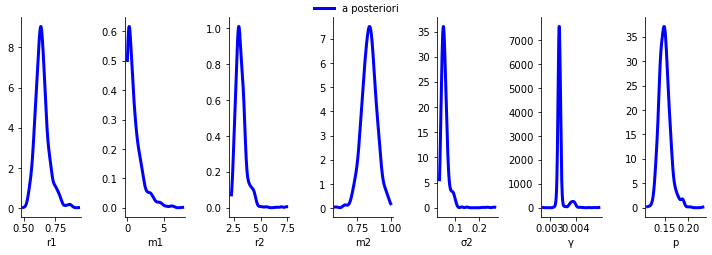

In [68]:
print(trace.mean(), log_marg, DIC, WAIC)
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace[f.parm_names[k]]), max(trace[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace[f.parm_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")
    # axs[k].plot(trace[f.parm_names[k]], lw=3, label = "a posteriori", color = "blue")

    # axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    # axs[k].set_yticks([])
    # axs[k].set_yticks(np.round(
    #     trace[f.parm_names[k]].quantile([0.0005, 0.9995]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

In [113]:
f.set_logp(X)
f.logp(trace.mean().values)


-834.7922264100278

In [19]:
f = bsm.loss_model("Gamma-Pareto", ["r", "α", "γ"])
r_prior, α_prior, γ_prior = bsm.prior_model('gamma','r', 1, 1),\
bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','γ', 1, 1)
prior_spliced_model = bsm.independent_priors([r_prior, α_prior, γ_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.00042629241943359375 ;ESS: 998 ;steps:4 ;particle moved: 99.8%
Generation: 2 ;temperature: 0.001231975451901235 ;ESS: 1000 ;steps:3 ;particle moved: 98.75%
Generation: 3 ;temperature: 0.0028150527342223983 ;ESS: 999 ;steps:3 ;particle moved: 98.95%
Generation: 4 ;temperature: 0.005819660177375553 ;ESS: 999 ;steps:4 ;particle moved: 99.8%
Generation: 5 ;temperature: 0.011084789524985013 ;ESS: 1000 ;steps:4 ;particle moved: 99.9%
Generation: 6 ;temperature: 0.01955674557546362 ;ESS: 999 ;steps:4 ;particle moved: 99.9%
Generation: 7 ;temperature: 0.0328522342091168 ;ESS: 999 ;steps:4 ;particle moved: 100.0%
Generation: 8 ;temperature: 0.05186286566038205 ;ESS: 999 ;steps:4 ;particle moved: 99.95%
Generation: 9 ;temperature: 0.07903355383286526 ;ESS: 1000 ;steps:4 ;particle moved: 99.6%
Generation: 10 ;temperature: 0.1173484234640246 ;ESS: 999 ;steps:4 ;particle moved: 99.8%
Generation: 11 ;temp

r    25.357702
α     1.342095
γ     1.235861
dtype: float64
-3896.3161944959 7720.658739902265 7735.560270061581


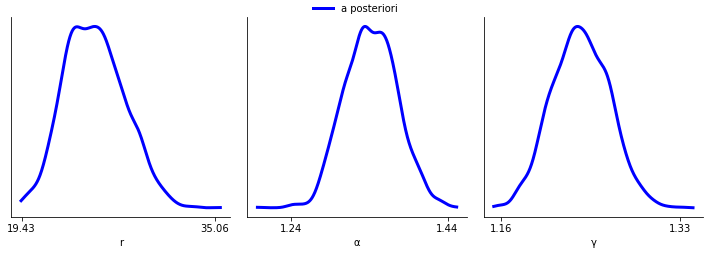

In [21]:
print(trace.mean())
print(log_marg, DIC, WAIC)
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace[f.parm_names[k]]), max(trace[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace[f.parm_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    # axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xticks(np.round(
        trace[f.parm_names[k]].quantile([0.0005, 0.9995]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()